In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.serif"] = "Times New Roman"


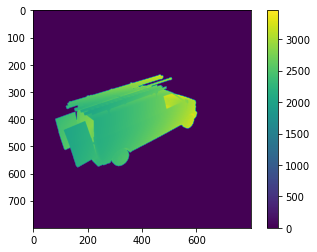

In [2]:
fn = './results-views72'
mesh_fn = './assets/0.obj'
id = 0
depth = np.load(os.path.join(fn, '%06d_depth.npy'%id)).astype(np.float32)
plt.imshow(depth)
plt.colorbar()

In [3]:
valid_rows, valid_cols = np.where(depth > 0)
print(valid_rows.shape)
pix_coords = np.stack((valid_cols, valid_rows, np.ones(valid_rows.shape)), axis=0)
print(pix_coords.shape)

(104521,)
(3, 104521)


In [4]:
K = np.loadtxt(os.path.join(fn, 'cam_intr.txt'))
cam_to_world = np.loadtxt(os.path.join(fn, 'cam_ext.txt')) # NOTE: extrinsic is defined for coordinates with unit meters
cam_coords = np.matmul(np.linalg.inv(K), pix_coords)
print(K)
print(cam_to_world)

[[693.24523926   0.         400.        ]
 [  0.         693.24523926 400.        ]
 [  0.           0.           1.        ]]
[[ 6.85352981e-01  2.65592843e-01 -6.78049982e-01  2.00000000e+00]
 [ 7.28211045e-01 -2.49961644e-01  6.38144076e-01 -2.00000000e+00]
 [ 7.80816123e-09 -9.31117415e-01 -3.64719570e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
depth_vals = depth[valid_rows, valid_cols].reshape((1, -1))
cam_coords = cam_coords * depth_vals
print(cam_coords.shape)
print(cam_coords)


(3, 104521)
[[ 294.89564215  299.66884478  304.35117048 ... -745.19660684
  -743.05595023 -745.53703471]
 [-762.98396303 -763.21908906 -763.21908906 ...  555.73984239
   556.50147762  559.15277603]
 [3245.         3246.         3246.         ... 2189.
  2192.         2190.        ]]


In [6]:
# world with units meters
cam_coords_homo = np.concatenate((cam_coords / 1000.0, np.ones((1, cam_coords.shape[1]))), axis=0)
world_coords = np.matmul(cam_to_world, cam_coords_homo)
print(world_coords)

[[-0.20080766 -0.19827683 -0.19506779 ...  0.1526264   0.15226164
   0.15262149]
 [ 0.47624052  0.48041333  0.48382305 ... -1.28467666 -1.28139376
  -1.28513952]
 [ 0.52691265  0.52676686  0.52676686 ... -0.31583019 -0.31763352
  -0.31937275]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


In [7]:
import open3d as o3d
mesh = o3d.io.read_triangle_mesh(mesh_fn, enable_post_processing=False)

center = mesh.get_center()
mesh.translate(-center)

scale = 2.2
factor = max(mesh.get_max_bound() - mesh.get_min_bound()) / scale
mesh.scale(1/factor, mesh.get_center())

# verts = np.asarray(mesh.vertices)
### !!!!! to be aligned with blender 
### !!!!! where up is Y and forward is Z
verts = np.asarray(mesh.vertices)[:, [0,2,1]]
verts[:,1] *= -1

print(verts.shape)
verts_homo = np.concatenate((verts, np.ones((verts.shape[0], 1))), axis=1)
verts_wrd2cam = np.matmul(np.linalg.inv(cam_to_world), verts_homo.T)
verts_wrd2cam = verts_wrd2cam / verts_wrd2cam[3:]

verts_cam2img = np.matmul(K, verts_wrd2cam[:3])
verts_cam2img = verts_cam2img / verts_cam2img[2:]
print(verts_cam2img)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(53306, 3)
[[479.0806111  479.98701612 480.60793767 ... 418.8727533  420.037659
  420.96887285]
 [337.86303365 337.59583529 338.83348599 ... 276.90065175 277.66385785
  277.55937884]
 [  1.           1.           1.         ...   1.           1.
    1.        ]]


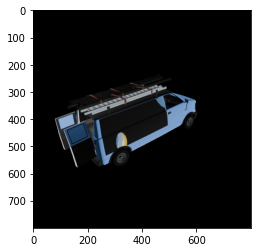

In [8]:
img = cv2.imread(os.path.join(fn, '%06d.png'%id))
H,W,_ = img.shape
plt.imshow(img[:,:,::-1])

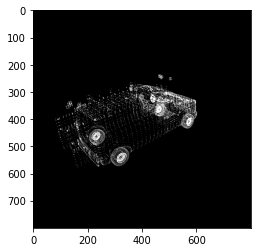

In [9]:
new_img = np.zeros_like(img)
us = verts_cam2img[0].astype(np.int16)
us[us<0] = 0
us[us>W-1] = W-1

vs = verts_cam2img[1].astype(np.int16)
vs[vs<0] = 0
vs[vs>H-1] = H-1
inds = np.asarray([vs, us], dtype=np.int16)
new_img[tuple(inds)] = 255
plt.imshow(new_img)